Nurvirta Monarizqa 

16/9/2020

Plot kasus aktif Covid-19 harian per provinsi

Style: https://www.endcoronavirus.org/states

Data: kawalcovid19.id

In [204]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rcParams
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
rcParams['font.family'] = 'monospace'
import numpy as np
from sklearn.cluster import KMeans



# 1. Load Data

## 1.a. Letak Provinsi dalam grid

In [205]:
indo_grid = pd.read_csv("../Indonesia_GeoJSON/indo_grid.csv", index_col=0)
indo_grid.index = range(len(indo_grid))
indo_grid.columns =range(len(indo_grid.columns))
indo_index = indo_grid.T.stack()

## 1.b. Kasus dari kawalcovid19.id
https://docs.google.com/spreadsheets/d/1ma1T9hWbec1pXlwZ89WakRk-OfVUQZsOCFl4FwZxzVw/edit
Tab "Timeline"

In [206]:
data = pd.read_csv("kawalcovid/20200916.csv")
ix_sep = data[data.Aceh=="Aceh"]['Total Kasus'].index
ix_sep

Int64Index([184, 372, 554, 736, 918, 1103], dtype='int64')

In [207]:
data[data.Aceh=="Aceh"]

,Total Kasus,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,...,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?,Unnamed: 36
184,Kasus Harian,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,...,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?,NaN
372,Kasus Aktif,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,...,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?,NaN
554,Sembuh,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,...,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?,NaN
736,Sembuh Harian,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,...,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?,NaN
918,Meninggal Dunia,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,...,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?,NaN
1103,Meninggal Dunia Harian,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,...,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?,NaN


Dari dataframe di atas terlihat bahwa di satu sheet terdapat beberapa tabel, mari kita pisahkan dengan keberadaan header di tiap tabel sebagai penentu (ix_sep)

In [208]:
total_kasus = data.iloc[:ix_sep[0]-1,:].set_index("Total Kasus")
kasus_harian = data.iloc[ix_sep[0]+1:ix_sep[1]-1,:].set_index("Total Kasus")
kasus_aktif = data.iloc[ix_sep[1]+1:ix_sep[2]-1,:].set_index("Total Kasus")
sembuh = data.iloc[ix_sep[2]+1:ix_sep[3]-1,:].set_index("Total Kasus")
sembuh_harian = data.iloc[ix_sep[3]-1:ix_sep[4]+1,:].set_index("Total Kasus")
meninggal = data.iloc[ix_sep[4]-1:ix_sep[5]+1,:].set_index("Total Kasus")
meninggal_harian = data.iloc[ix_sep[5]-1:,:].set_index("Total Kasus")

In [209]:
total_kasus.head()

,Aceh,Bali,Banten,Babel,Bengkulu,DIY,Jakarta,Jambi,Jabar,Jateng,...,Riau,Malut,Maluku,Papbar,Papua,Sulbar,NTT,Gorontalo,?,Unnamed: 36
Total Kasus,,,,,,,,,,,,,,,,,,,,,
18-Mar,0,1,17,0,0,3,158,0,24,8,...,1,0,0,0,0,0,0,0,0,NaN
19-Mar,0,1,27,0,0,5,210,0,26,12,...,2,0,0,0,0,0,0,0,0,NaN
20-Mar,0,4,37,0,0,4,215,0,41,12,...,1,0,0,0,0,0,0,0,13,NaN
21-Mar,0,3,43,0,0,5,267,0,55,14,...,1,0,0,0,0,0,0,0,10,NaN
22-Mar,0,3,47,0,0,5,307,0,59,15,...,1,0,1,0,2,0,0,0,6,NaN


# 2. Olah Data

## 2.a. Convert data to numeric, simpan rolling average (7 hari)


In [210]:
def process_data(df):
    df = df.iloc[:-1,:] #just in case the last day's data hasn't updated
    col = df.columns
    all_data = []
    all_data_rolling = []
    for i in range(34):
        the_data = pd.to_numeric(df[col[i]].fillna(0).apply(lambda x: str(x).replace(",","")))
        the_data_rolling = the_data.rolling(7).mean()
        all_data.append(the_data)
        all_data_rolling.append(the_data_rolling)
    processed = pd.concat(all_data, axis=1)
    processed_rolling = pd.concat(all_data_rolling, axis=1).dropna()
    processed.index = pd.to_datetime(pd.Series([x+"-2020" for x in processed.index]))
    processed_rolling.index = pd.to_datetime(pd.Series([x+"-2020" for x in processed_rolling.index]))
    return processed, processed_rolling

In [211]:
aktif, aktif_rolling = process_data(kasus_aktif)
harian, harian_rolling = process_data(kasus_harian)

## 2.b Menentukan metric
Metric yang akan digunakan adalah progress zero (P0) yakni 100%-(A/B) di mana

A = rolling average kasus baru dari H-6 hingga H di mana H adalah hari ini

B = puncak rolling average 7 hari

In [293]:
max_day =  list(zip(harian_rolling.idxmax().index, harian_rolling.idxmax().values))
max_harian_day = harian_rolling.unstack().loc[max_day].reset_index(level=1)
max_harian_day.columns = ['tanggal_puncak','rolling_mean_puncak']
harian_latest = harian_rolling.iloc[-1]
harian_latest.name = "rolling_mean_terkini"
P0 = np.round((1-harian_latest/max_harian_day['rolling_mean_puncak'])*100,2)
P0.name = "P0"

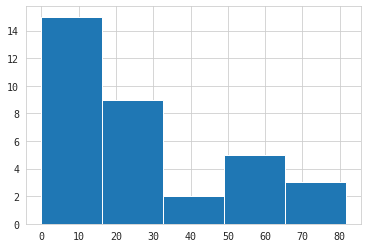

In [294]:
P0.hist(bins=5)

In [299]:
P0_cat = pd.cut(P0,[-1,0,70,100]).cat.codes
P0_cat.name = "category"

In [315]:
info = pd.concat([max_harian_day, harian_latest, P0, P0_cat,
                  # add grid
                  indo_index.reset_index().set_index(0)], axis=1)\
.dropna()

In [316]:
info.sort_values("P0")

,tanggal_puncak,rolling_mean_puncak,rolling_mean_terkini,P0,category,level_0,level_1
Aceh,2020-09-15,139.714286,139.714286,0.00,0.0,0,0
Sumut,2020-09-15,139.428571,139.428571,0.00,0.0,0,1
Lampung,2020-09-15,25.428571,25.428571,0.00,0.0,1,5
Riau,2020-09-15,174.714286,174.714286,0.00,0.0,1,2
NTT,2020-09-15,9.571429,9.571429,0.00,0.0,12,6
Papua,2020-09-15,67.857143,67.857143,0.00,0.0,15,2
Papbar,2020-09-15,42.142857,42.142857,0.00,0.0,14,2
DIY,2020-09-15,42.857143,42.857143,0.00,0.0,5,7
Jakarta,2020-09-13,1126.714286,1111.714286,1.33,1.0,4,5
Jabar,2020-09-10,278.428571,270.428571,2.87,1.0,4,6


# 3. Plot

In [340]:
#https://coolors.co/461220-8c2f39-b23a48-f9958a-daa107-f0d893
linecolors = {0:'#461220',1:'#b23a48',2:'#daa107'}
fillcolors = {0:'#461220',1:'#f9958a',2:'#f0d893'}

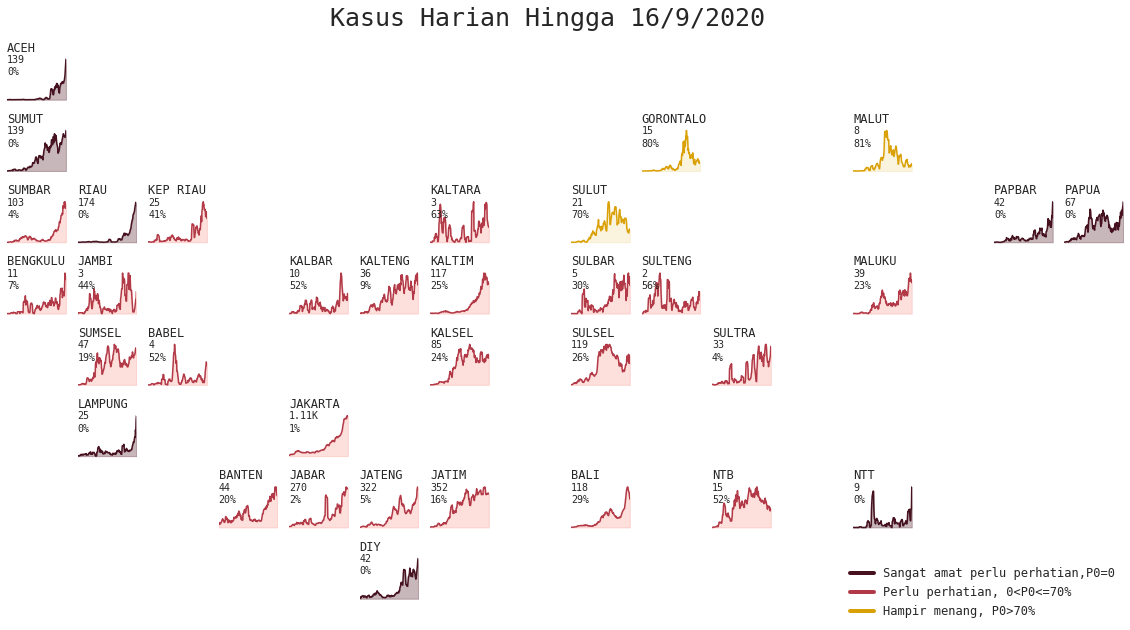

In [386]:
fig, axs = plt.subplots(8,16, figsize=(20,10))
for col in info.index:
    # subset data
    the_data = harian_rolling.loc[:,col]
    colorfill = fillcolors[info.loc[col,'category']]
    color = linecolors[info.loc[col,'category']]
    
    # grid positioning
    y = int(info.loc[col]['level_0'])
    x = int(info.loc[col]['level_1'])
    ax = axs[x,y]
    
    # plot data
    the_data.plot(ax=ax, color=color)
    ax.set_title(col.upper(), x=0,y=1, fontsize=12, loc='left')
    ax.set_xlabel("")
    l1 = ax.lines[0]
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    ax.fill_between(x1,y1, color=colorfill, alpha=0.3)
    
    # number and label styling
    number = int(y1[-1])
    if number > 1000:
        numbertext = str(np.round(np.float(y1[-1]/1000),2))+"K"
    else:
        numbertext = str(number)
    ax.text(x=0,y=0.88,s=numbertext, transform=ax.transAxes, 
            fontsize=10)
    
    p0 = str(np.int(info.loc[col, "P0"]))+"%"
    ax.text(x=0,y=0.6,s=p0, transform=ax.transAxes, 
            fontsize=10)
    
# hapus semua border untuk subplot lain
for row in axs:
    for ax in row:
        plt.subplots_adjust(hspace = 0.6)
        ax.axis("off")

# judul
plt.suptitle("Kasus Harian Hingga 16/9/2020", fontsize=25, y=0.95)
legend_elements = [Line2D([0], [0], color=linecolors[0], lw=4, label='Sangat amat perlu perhatian,P0=0'),
                    Line2D([0], [0], color=linecolors[1], lw=4, label='Perlu perhatian, 0<P0<=70%'),
                   Line2D([0], [0], color=linecolors[2], lw=4, label='Hampir menang, P0>70%')]

# legenda
leg = plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), fontsize=12)
leg.get_frame().set_linewidth(0.0)

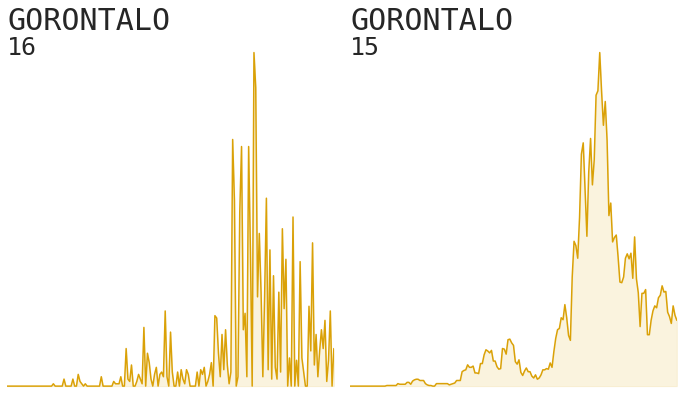

In [363]:
    fig = plt.figure(figsize=(12,6.75))
    data = [harian['Gorontalo'],harian_rolling['Gorontalo']]
    for i, the_data in enumerate(data):
        ax = fig.add_subplot(121+i)
        the_data.plot(ax=ax, color=color)
        ax.set_title(col.upper(), x=0,y=1, fontsize=30, loc='left')
        ax.set_xlabel("")
        l1 = ax.lines[0]
        x1 = l1.get_xydata()[:,0]
        y1 = l1.get_xydata()[:,1]
        ax.fill_between(x1,y1, color=colorfill, alpha=0.3)

        # number and label styling
        number = int(y1[-1])
        if number > 1000:
            numbertext = str(np.round(np.float(y1[-1]/1000),2))+"K"
        else:
            numbertext = str(number)
        ax.text(x=0,y=0.95,s=numbertext, transform=ax.transAxes, 
                fontsize=25)
        ax.axis("off")
        plt.subplots_adjust(wspace=0.05)

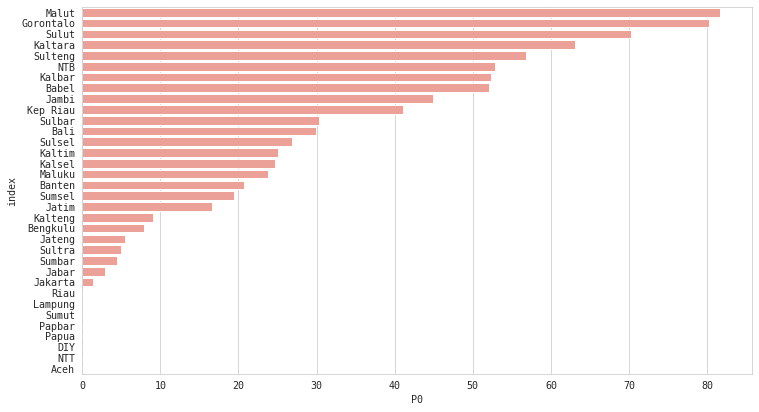

In [381]:

f, ax = plt.subplots(figsize = (12,6.75))
sns.barplot(x = 'P0', y = 'index', data = info.reset_index().sort_values("P0", ascending=False),
            label = 'P0', color = fillcolors[1], edgecolor = 'w', ax=ax)
# sns.barplot(x = 'P0', y = 'index', data = info.reset_index().sort_values("P0", ascending=False).head(2),
#             label = 'P0', color = 'y', edgecolor = 'w', ax=ax)

In [382]:
info.to_csv("info.csv")